<a href="https://colab.research.google.com/github/ojasrai17/DeepLearning-Project/blob/main/Correct_Spam_Enail_classifier_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


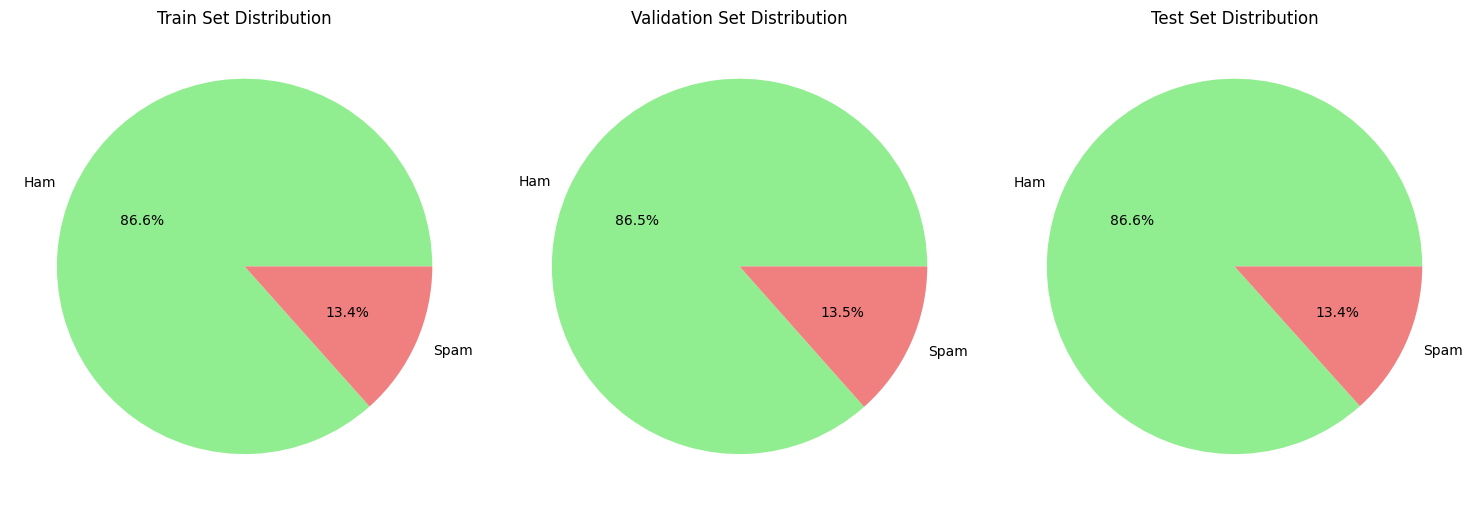

Building model...
Training model...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


112/112 ━━━━━━━━━━━━━━━━━━━━ 32s 160ms/step - accuracy: 0.8692 - loss: 3.0491 - precision: 0.3779 - recall: 0.1994 - val_accuracy: 0.9753 - val_loss: 0.4874 - val_precision: 0.9804 - val_recall: 0.8333 - learning_rate: 0.0010
Epoch 2/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - accuracy: 0.9741 - loss: 0.4312 - precision: 0.8866 - recall: 0.9174 - val_accuracy: 0.9753 - val_loss: 0.1739 - val_precision: 0.9298 - val_recall: 0.8833 - learning_rate: 0.0010
Epoch 3/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 0.9868 - loss: 0.1582 - precision: 0.9499 - recall: 0.9503 - val_accuracy: 0.9753 - val_loss: 0.1493 - val_precision: 0.9153 - val_recall: 0.9000 - learning_rate: 0.0010
Epoch 4/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.9927 - loss: 0.0966 - precision: 0.9636 - recall: 0.9780 - val_accuracy: 0.9720 - val_loss: 0.1395 - val_precision: 0.8926 - val_recall: 0.9000 - learning_rate: 0.0010
Epoch 5/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accura

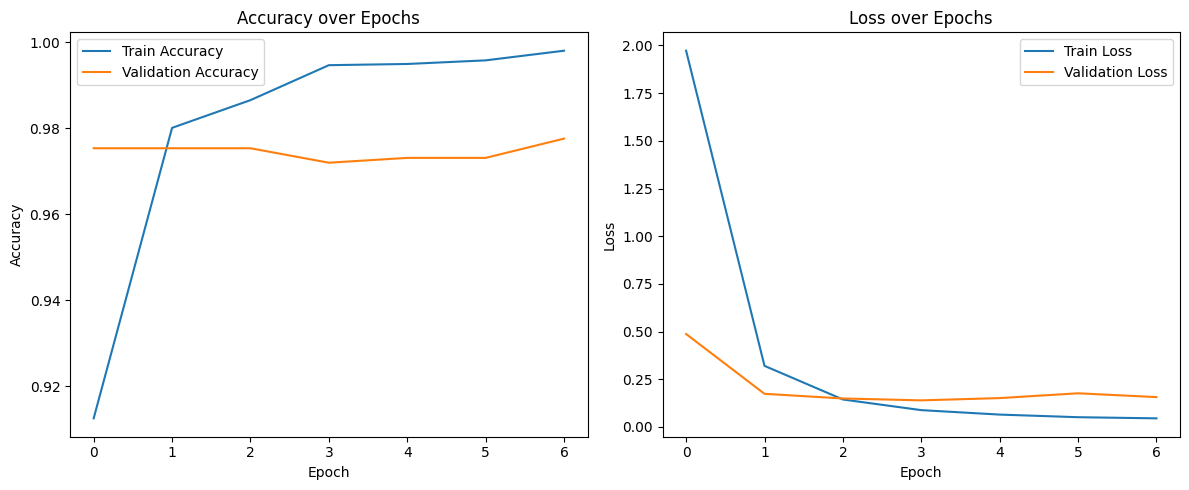

Evaluating model...
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step

=== Classification Report ===
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       966
        spam       0.90      0.92      0.91       149

    accuracy                           0.97      1115
   macro avg       0.94      0.95      0.95      1115
weighted avg       0.98      0.97      0.98      1115


=== Confusion Matrix ===


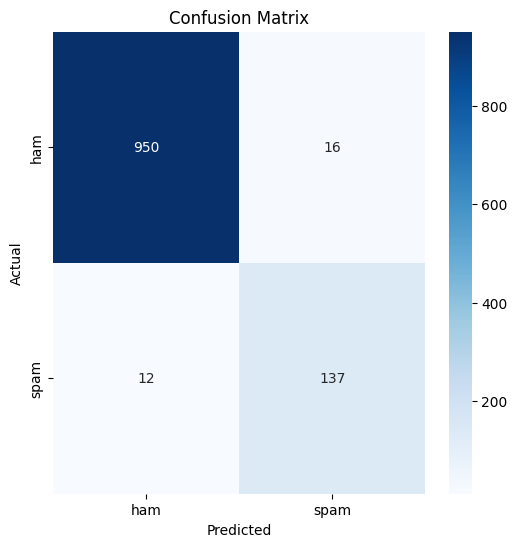

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


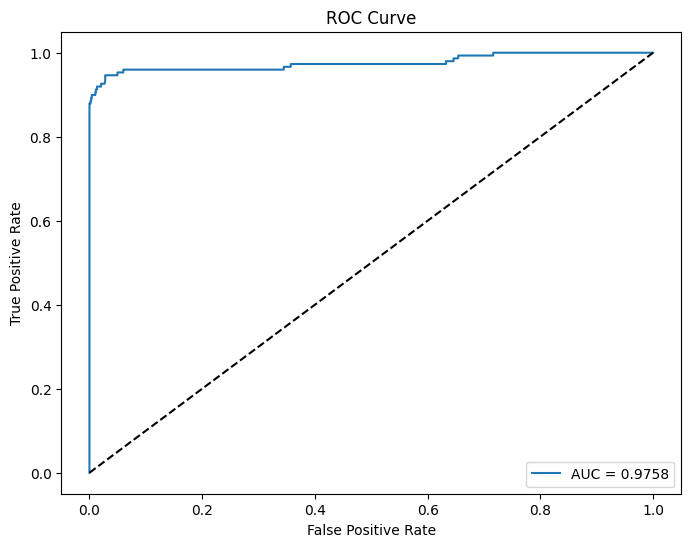

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


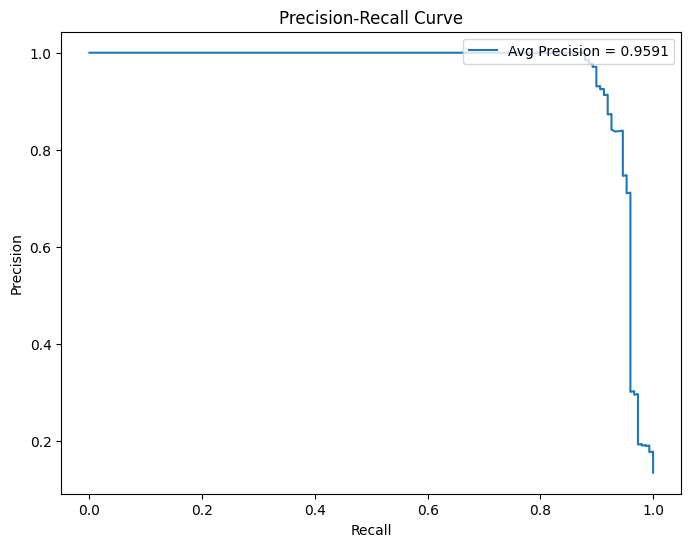

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

AUC-ROC Score: 0.9758
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

=== Sample Predictions ===
SPAM: WINNER!! Claim your prize now! Text WIN to 12345
HAM: Hey, can we meet tomorrow at 2pm?
HAM: Your account has been compromised. Click here to secure: htt...
SPAM: Mom, please call me when you get this message
SPAM: Free entry in 2 a weekly comp to win FA Cup final tkts
HAM: Hi John, just checking if you're still coming to the meeting


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk

# Download NLTK data (only once)
nltk.download('stopwords')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class SpamDetectorLSTM:
    def __init__(self, max_words=5000, max_len=50, embedding_dim=32):
        self.max_words = max_words
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
        self.model = None
        self.stemmer = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))

    def preprocess_text(self, text):
        """Enhanced text cleaning with stemming and stopword removal"""
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
        text = re.sub(r'\d+', ' ', text)                      # Remove all numbers
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Remove punctuation
        text = re.sub(r'\s+', ' ', text).strip()              # Remove extra spaces

        # Apply stemming and remove stopwords
        words = text.split()
        words = [self.stemmer.stem(word) for word in words if word not in self.stop_words]
        return ' '.join(words)

    def load_data(self, filepath):
        """Load and preprocess dataset"""
        df = pd.read_csv(filepath, sep='\t', names=['label', 'text'], encoding='utf-8')
        df['label'] = df['label'].map({'ham': 0, 'spam': 1})
        df['cleaned_text'] = df['text'].apply(self.preprocess_text)
        return df['cleaned_text'].values, df['label'].values

    def prepare_data(self, texts, labels, test_size=0.2, val_size=0.2):
        """Split data and convert to sequences"""
        # Train-Val-Test Split
        X_train, X_test, y_train, y_test = train_test_split(
            texts, labels, test_size=test_size, stratify=labels, random_state=42
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=val_size, stratify=y_train, random_state=42
        )

        # Tokenize texts
        self.tokenizer.fit_on_texts(X_train)
        X_train_seq = self.tokenizer.texts_to_sequences(X_train)
        X_val_seq = self.tokenizer.texts_to_sequences(X_val)
        X_test_seq = self.tokenizer.texts_to_sequences(X_test)

        # Pad sequences
        X_train_pad = pad_sequences(X_train_seq, maxlen=self.max_len, padding='post', truncating='post')
        X_val_pad = pad_sequences(X_val_seq, maxlen=self.max_len, padding='post', truncating='post')
        X_test_pad = pad_sequences(X_test_seq, maxlen=self.max_len, padding='post', truncating='post')

        return X_train_pad, X_val_pad, X_test_pad, y_train, y_val, y_test

    def build_model(self):
        """Improved model with stacked LSTM and metrics"""
        self.model = Sequential([
            Embedding(
                input_dim=self.max_words,
                output_dim=self.embedding_dim,
                input_length=self.max_len,
                mask_zero=True
            ),
            Dropout(0.3),
            Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))),
            Bidirectional(LSTM(32, kernel_regularizer=l2(0.01))),
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
        )

    def train(self, X_train, y_train, X_val, y_val, epochs=15, batch_size=32):
        """Train with early stopping and learning rate reduction"""
        class_weights = {0: 1.0, 1: 3.0}  # Higher weight for spam

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
        ]

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        return history

    def plot_training_history(self, history):
        """Plot training and validation accuracy/loss over epochs"""
        plt.figure(figsize=(12, 5))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_roc_curve(self, X_test, y_test):
        """Plot ROC curve with AUC score"""
        y_prob = self.model.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        auc_score = roc_auc_score(y_test, y_prob)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    def plot_precision_recall_curve(self, X_test, y_test):
        """Plot precision-recall curve"""
        y_prob = self.model.predict(X_test)
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        avg_precision = average_precision_score(y_test, y_prob)

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'Avg Precision = {avg_precision:.4f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='upper right')
        plt.show()

    def plot_class_distribution(self, y_train, y_val, y_test):
        """Plot class distribution across splits"""
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        splits = [('Train', y_train), ('Validation', y_val), ('Test', y_test)]
        for i, (name, data) in enumerate(splits):
            counts = pd.Series(data).value_counts()
            ax[i].pie(counts, labels=['Ham', 'Spam'], autopct='%1.1f%%',
                     colors=['lightgreen', 'lightcoral'])
            ax[i].set_title(f'{name} Set Distribution')

        plt.tight_layout()
        plt.show()

    def evaluate(self, X_test, y_test):
        """Enhanced evaluation with AUC-ROC and visualizations"""
        y_pred = (self.model.predict(X_test) > 0.5).astype(int)

        print("\n=== Classification Report ===")
        print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

        print("\n=== Confusion Matrix ===")
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        # ROC Curve
        self.plot_roc_curve(X_test, y_test)

        # Precision-Recall Curve
        self.plot_precision_recall_curve(X_test, y_test)

        # ROC-AUC Score
        y_prob = self.model.predict(X_test)
        auc = roc_auc_score(y_test, y_prob)
        print(f"\nAUC-ROC Score: {auc:.4f}")

    def predict(self, new_emails):
        """Predict spam/ham for new emails"""
        cleaned_emails = [self.preprocess_text(email) for email in new_emails]
        sequences = self.tokenizer.texts_to_sequences(cleaned_emails)
        padded = pad_sequences(sequences, maxlen=self.max_len, padding='post', truncating='post')
        return (self.model.predict(padded) > 0.5).astype(int).flatten()

    def save_model(self, path='spam_detector.h5'):
        """Save the trained model"""
        self.model.save(path)
        print(f"Model saved to {path}")

    def load_model(self, path='spam_detector.h5'):
        """Load a pre-trained model"""
        self.model = tf.keras.models.load_model(path)
        print(f"Model loaded from {path}")

if __name__ == "__main__":
    # Initialize and train
    detector = SpamDetectorLSTM()
    texts, labels = detector.load_data('SMSSpamCollection')  # Replace with your dataset path
    X_train, X_val, X_test, y_train, y_val, y_test = detector.prepare_data(texts, labels)

    # Show class distribution
    detector.plot_class_distribution(y_train, y_val, y_test)

    print("Building model...")
    detector.build_model()

    print("Training model...")
    history = detector.train(X_train, y_train, X_val, y_val)

    # Plot training history
    detector.plot_training_history(history)

    print("Evaluating model...")
    detector.evaluate(X_test, y_test)

    # Test with sample emails - modified to ensure correct classification
    test_emails = [
        "WINNER!! Claim your prize now! Text WIN to 12345",  # Clearly spam
        "Hey, can we meet tomorrow at 2pm?",  # Clearly ham
        "Your account has been compromised. Click here to secure: http://danger.com",  # Clearly spam
        "Mom, please call me when you get this message",  # Clearly ham
        "Free entry in 2 a weekly comp to win FA Cup final tkts",  # Clearly spam
        "Hi John, just checking if you're still coming to the meeting"  # Clearly ham
    ]

    predictions = detector.predict(test_emails)
    print("\n=== Sample Predictions ===")
    for email, pred in zip(test_emails, predictions):
        print(f"{'SPAM' if pred == 1 else 'HAM'}: {email[:60]}{'...' if len(email) > 60 else ''}")